In [165]:
import numpy as np
import scipy
from scipy import special
from scipy import integrate
from scipy import interpolate
from scipy import stats
from scipy import optimize
from numpy.random import default_rng

import time

import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

<h1>Making an NFW halo</h1>

<h2>Important equations:</h2>

mass density $\rho (r)$:
\begin{equation}
\rho (r) = \frac{\rho_o}{\frac{r}{a}\left(1+\frac{r}{a}\right)^2}
\end{equation}

total mass at radius r $M (r)$:
\begin{equation}
M (r) = 4 \pi \rho_o a^3 \left( ln\left(1+\frac{r}{a}\right) - \frac{\frac{r}{a}}{1+\frac{r}{a}}\right)
\end{equation}

potential at radius r $\Phi (r)$:
\begin{equation}
\Phi (r) = -4 \pi G \rho_o a^2 \frac{ln\left(1+\frac{r}{a}\right)}{\frac{r}{a}}
\end{equation}

We can define some distant radius $r_\Delta$ where $\rho (r_\Delta)=\Delta\cdot\rho_c$ where $\rho_c$ is the cosmological critical density and $\Delta$ is some number, usually 200. This radius $r_\Delta$ is usually quite a bit bigger than the scale radius a, and the ratio between these quantities is usually characterized by the "concentration" of the halo:
$c=\frac{r_\Delta}{a}$

<h2>Generating the radial distribution</h2>
The differential bit of mass contained in a shell of thickness dr at radius r is given by:
\begin{equation}
    dM(r) = 4\pi r^2 \rho (r) dr.
\end{equation}

Integrating this differential shell of mass up to some radius tells how much mass in enclosed in a volume up to a certain volume. Dividing by some total mass (defined by the mass enclosed at $r_\Delta$) we now have an idea of what fraction of mass is enclosed up to any radius. This is equivalent to the cumulative distribution function for the radius of tracers in the halo:
\begin{equation}
    \text{CDF(r)} = \frac{M(r)}{M(r_{200})} = \frac{\int_0^r {r'}^2 \frac{\rho0}{\left(\frac{r'}{a}\right)\left(1+\frac{r'}{a}\right)^2} dr'} {\int_0^{r_{200}} {r'}^2 \frac{\rho0}{\left(\frac{r'}{a}\right)\left(1+\frac{r'}{a}\right)^2} dr'}
\end{equation}

We can pick a radius at random, but that will only create a flat probability distribution in r. We need a way to systematic way to encode the bumpiness of the distribution in our random number generation. Since we can explicitly compute the CDF we can sample a better way: inverse transform sampling.

The CDF for the radii of tracers in the halo can be written in terms of nice dimensionless variables:
\begin{equation}
    \text{CDF}(\chi) = \frac{ln(1+c\chi) - \frac{c\chi}{1+c\chi}} {ln(1+c) - \frac{c}{1+c}};\:(0<\chi<1)
\end{equation}

where $\chi=\frac{r}{r_\Delta}$ and $c=\frac{r_\Delta}{a}$ (as previously defined).

In [452]:
class haloNFW(): # Our NFW halo object
    def __init__(self,nTracers,rScale,rho0,delta,rhoCritical=1.26*10**-7):
        """
        NFW Halo. This init just stores some of the arguments passed in and computes some important/handy quantities.
        """
        self.nTracers = nTracers
        self.rScale = rScale # this is sometimes called a
        self.rho0 = rho0
        self.delta = delta
        self.rhoCritical = rhoCritical # solar masses/Mpc^3
        rhoNorm = self.rho0/(self.delta*self.rhoCritical)
        cShortcut = ((3.*np.sqrt(81.*rhoNorm**2. + 12.*rhoNorm) + 27.*rhoNorm + 2.)/2.)**(1./3.)
        
        self.c = ( cShortcut + 1./cShortcut - 2 )/3.
        self.rDelta = self.c*self.rScale
        self.G = 4.3009*10**-3 # Newton's constant, (pc/solar mass) * (km/second)^2
        self.mHalo = (4*np.pi*self.rho0*self.rScale**3)*self.gFcn(self.c) # Should be in units of solar masses
        self.virialSpeed = np.sqrt(self.G*self.mHalo/self.rDelta)
        
    def nfwPotential(self, radiusNorm):
        """
        The potential (integrated GM/r^2 from +inf to r) at a given normalized radius.
        """
        return -(4*np.pi*self.rho0*self.G*self.rScale**2)*(np.log(1+self.c*radiusNorm)/(self.c*radiusNorm))
        
    def radialCDF(self,radiusNorm):
        """
        This is the radial cumulative distribution function for an NFW halo. Takes an un-normalized radius and spits out the probability for
        r to be between 0 and the input radius. When paired with inverse transform sampling, you can rebuild the radial distribution function
        with a small set of tracers.
        """
        if 0<=radiusNorm<=1:
            return self.gFcn(self.c*radiusNorm)/self.gFcn(self.c)
        else:
            print("Out of acceptable radial bounds")
    
    def randomNum(self,n=1):
        """
        Basic implementation of the new scipy random number generation. Creates a new generator and calls the .random(n) method
        which returns n random numbers uniformly distributed between 0 and 1.
        """
        return default_rng().random(n) # generates n random numbers
    
    def inverseTransformSampling(self, CDF, bracket, nSamples):
        """
        Simple implementation of inverseTransformSampling. Currently a little slow since I need to loop though each sample instead of doing it
        in one step that can be parallelized. You win some, you lose some. Anyways, this takes any cumulative distribution function (CDF), subtracts
        some random offset from it between 0 and 1, and then finds the root of that offset CDF. When you repeat this process and record the roots,
        you actually recover the original distribution function and can draw from it truly at random.
        """
        result = []
        CDFsubRandomNumber = lambda x: CDF(x) - self.randomNum(1) # Need a modified CDF where we subtract some random offset each time it's called.
        for i in range(nSamples):
            result.append( optimize.root_scalar( CDFsubRandomNumber , bracket = bracket ).root )
        
        return result
    
    def genTracerCoords(self):
        """
        Our halo needs tracer stars, and those tracer stars need coordinates! (otherwise they wouldn't be anywhere...) You should probably avoid
        calling this function, since the calculation of velocities will actually need the list of radii this function generates. If you were to
        generate these radii, then generate velocities, but then generate radii again the velocities wouldn't update. So this should only be called
        in the genTracers() method.
        
        This defines two class properties: radii and sphericalCoordinateAngles. radii is self-explanatory, sphericalCoordinateAngles is a 2-row array where the first
        row is the list of polar angles (theta) called like sphericalCoordinateAngles[0,:] and the second row is the list of azimuthal angles (phi) called like
        sphericalCoordinateAngles[1,:].
        """
        self.radii = self.inverseTransformSampling( self.radialCDF, bracket = (0, 1), nSamples = self.nTracers)
        self.radiiNorm = self.radii / self.rDelta
        self.coordAngles = np.array(
            [self.randomNum(self.nTracers)*np.pi,
             self.randomNum(self.nTracers)*2*np.pi]
        ) # first row is theta, second row is phi

    def gFcn(self,x):
        """
        Helper function since things like this turn up a lot in NFW profiles.
        """
        return np.log(1+x)-(x/(1+x))
    
    def radialVelocityDispersion(self,radiusNorm):
        """
        We are approximating the velocity distribution of the tracer stars with a Maxwell-Boltzmann distribution. The first moment of this
        distribution of radial velocities should be zero, so we're actually extracting the 2nd moment and calling it the dispersion. Then,
        I'm plugging this dispersion into a distribution of speeds (hopefully translating all of the factors correctly?) to get a speed distribution
        to generate random velocities from.
        """
        return np.sqrt(self.virialSpeed**2*\
                       ((self.c*radiusNorm*(1+self.c*radiusNorm)**2)/self.gFcn(self.c))*\
                       integrate.quad(lambda y: self.gFcn(y)/(y**3*(1+y)**2), self.c*radiusNorm, np.inf)[0]
                      )
    
    def speedPDF(self,speed,radiusNorm):
        """
        The probability distribution function for the speed of a tracer at a given radius. Supply this with a speed below the the virial speed or the kinematic limit
        and a radius below the virial radius, and this will return the probability to have that speed at that radius.
        """
        dispSquared = self.radialVelocityDispersion(radiusNorm)**2
        return (1/(2*np.pi*dispSquared))**(3/2)*(4*np.pi*speed**2)*np.exp(-speed**2/(2*dispSquared))
        
    def speedCDF(self,speed,radiusNorm):
        """
        Integrates the speed PDF up from 0 to the given speed, at a particular (normalized) radius.
        """
        dispSquared = self.radialVelocityDispersion(radiusNorm)**2
        #integrate.quad( lambda s: self.speedPDF(s,radiusNorm), 0, speed)[0]
        return special.erf(speed/np.sqrt(2*dispSquared)) - np.sqrt(2/(np.pi*dispSquared))*speed*np.exp(-speed**2/(2*dispSquared))
    
    def speedCDFeval(self,speed):
        return speedCDF
    
    def plotSpeedCDF(self,radiusNorm,steps=100):
        """
        Debug method to plot the CDF and see if it's behaving properly.
        """
        v = np.linspace(0,self.maxSpeed(radiusNorm),steps)
        cdf = []
        for i in range(steps):
            cdf.append(self.speedCDF(v[i], radiusNorm))
        plt.scatter(v,cdf)
        
    def plotSpeedPDF(self,radiusNorm,steps=100):
        """
        Debug method to plot the PDF and see if it's behaving properly.
        """
        v = np.linspace(0,self.maxSpeed(radiusNorm),steps)
        pdf = []
        for i in range(steps):
            pdf.append(self.speedPDF(v[i], radiusNorm))
        plt.scatter(v,pdf)
        
    def maxSpeed(self,radiusNorm):
        """
        Gives the max speed (the kinematic limit) at a particular radius. This is when a particle has enough kinetic energy to climb out of its potential (when KE=PE).
        """
        return np.sqrt(np.abs(2*self.nfwPotential(radiusNorm)))
    
    def genTracerVelocities(self):
        """
        This should build a list of tracer speeds + directions using the speedCDF we define earlier via inverse transform sampling.
        """
        self.speeds = []
        self.time = []
        self.time.append(time.time())
        for i in range(self.nTracers):
            self.speeds.append(self.inverseTransformSampling(lambda v: self.speedCDF(v,self.radiiNorm[i]), bracket = ( 0, self.maxSpeed(self.radiiNorm[i]) ), nSamples = 1)[0])
            if i % int(self.nTracers/10) == 0:
                self.time.append(time.time())
                print("step " + str(i) + ", average step time was: " + str((self.time[-1]-self.time[-2])/10))
        self.velocityAngles = np.array(\
                                       [self.randomNum(self.nTracers)*np.pi,\
                                        self.randomNum(self.nTracers)*2*np.pi]\
                                      ) # first row is theta, second row is phi

    def genTracers(self):
        """
        Should automatically generate a full set of tracer particles with coordinates and velocities that obey an NFW profile.
        """
        self.genTracerCoords()
        self.genTracerVelocities()
        self.sphericalPhaseSpacePoints = [self.radii,
                                          self.coordAngles,
                                          self.speeds,
                                          self.velocityAngles]

In [453]:
# Let's make a halo!

nTracers = 1000
rScale = 8.1*10**3 # Lin, Li "The Dark Matter Profiles in the Milky Way" https://arxiv.org/abs/1906.08419
mwHaloDensity = 7.18 * 10 ** -3 # Solar masses per cubic parsec, Milky way DM halo density (SOFUE 2011)
delta = 200
criticalDensity = 1.26 * 10 ** -7 # Solar masses per cubic parsec

mwHalo = haloNFW(nTracers,rScale,mwHaloDensity,delta,criticalDensity)

In [454]:
print('rScale is : '+str(mwHalo.rScale),', rDelta is: ' + str(mwHalo.rDelta))
print('the concentration must then be: ' + str(mwHalo.c))

rScale is : 8100.0 , rDelta is: 48041.27060252
the concentration must then be: 5.931021062039506


In [455]:
mwHalo.genTracerCoords()

48041.27060252


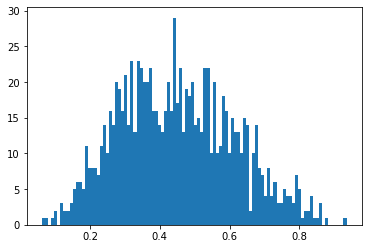

In [456]:
plt.hist(mwHalo.radii,100)
print(mwHalo.rDelta)

In [457]:
x = mwHalo.radii*np.sin(mwHalo.coordAngles[0,:])*np.cos(mwHalo.coordAngles[1,:])
y = mwHalo.radii*np.sin(mwHalo.coordAngles[0,:])*np.sin(mwHalo.coordAngles[1,:])
z = mwHalo.radii*np.cos(mwHalo.coordAngles[0,:])

68.0983347390944

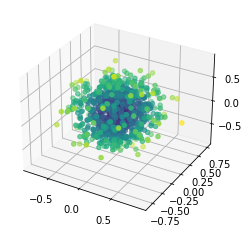

In [458]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x,y,z,c=mwHalo.radii)
mwHalo.virialSpeed

In [459]:
mwHalo.maxSpeed(.1)

199.9527404809701

In [460]:
mwHalo.genTracers()

step 0, average step time was: 0.002480006217956543
step 100, average step time was: 0.3161508560180664
step 200, average step time was: 0.3066763162612915
step 300, average step time was: 0.3080164670944214
step 400, average step time was: 0.3018652439117432
step 500, average step time was: 0.3106945276260376
step 600, average step time was: 0.3200193166732788
step 700, average step time was: 0.31114044189453127
step 800, average step time was: 0.3094047784805298
step 900, average step time was: 0.29690558910369874


(array([ 1.,  0.,  0.,  1.,  1.,  2.,  3.,  3.,  3.,  2.,  5.,  2.,  5.,
         7.,  7.,  6.,  8., 10., 10., 27., 15., 10., 10., 15., 21., 18.,
        28., 24., 16., 20., 23., 13., 25., 31., 22., 32., 26., 20., 23.,
        18., 26., 32., 19., 23., 23., 24., 20., 24., 15., 22., 17., 16.,
        13., 23., 18., 13., 10., 15., 16.,  9.,  9.,  7.,  4.,  8.,  8.,
         8.,  5.,  8.,  1.,  5.,  3.,  5.,  6.,  2.,  3.,  1.,  1.,  3.,
         3.,  0.,  0.,  2.,  4.,  0.,  1.,  1.,  2.,  0.,  0.,  1.,  1.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,
         0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

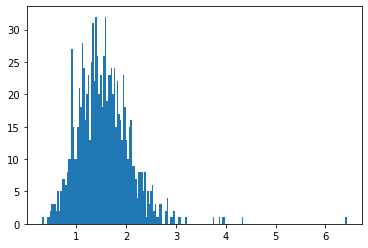

In [462]:
mwHalo.speeds[0:2]
plt.hist(mwHalo.speeds,200)